## Задание 1
-- Вывести распределение (количество) клиентов по сферам деятельности, отсортировав результат по убыванию количества.
```
select job_industry_category, count(distinct customer_id) as cnt
from hw2.customer 
where 
	job_industry_category is not null
	and job_industry_category != 'n/a' -- не особо полезная информация, если сфера не указана
group by 1
order by 2 desc
```

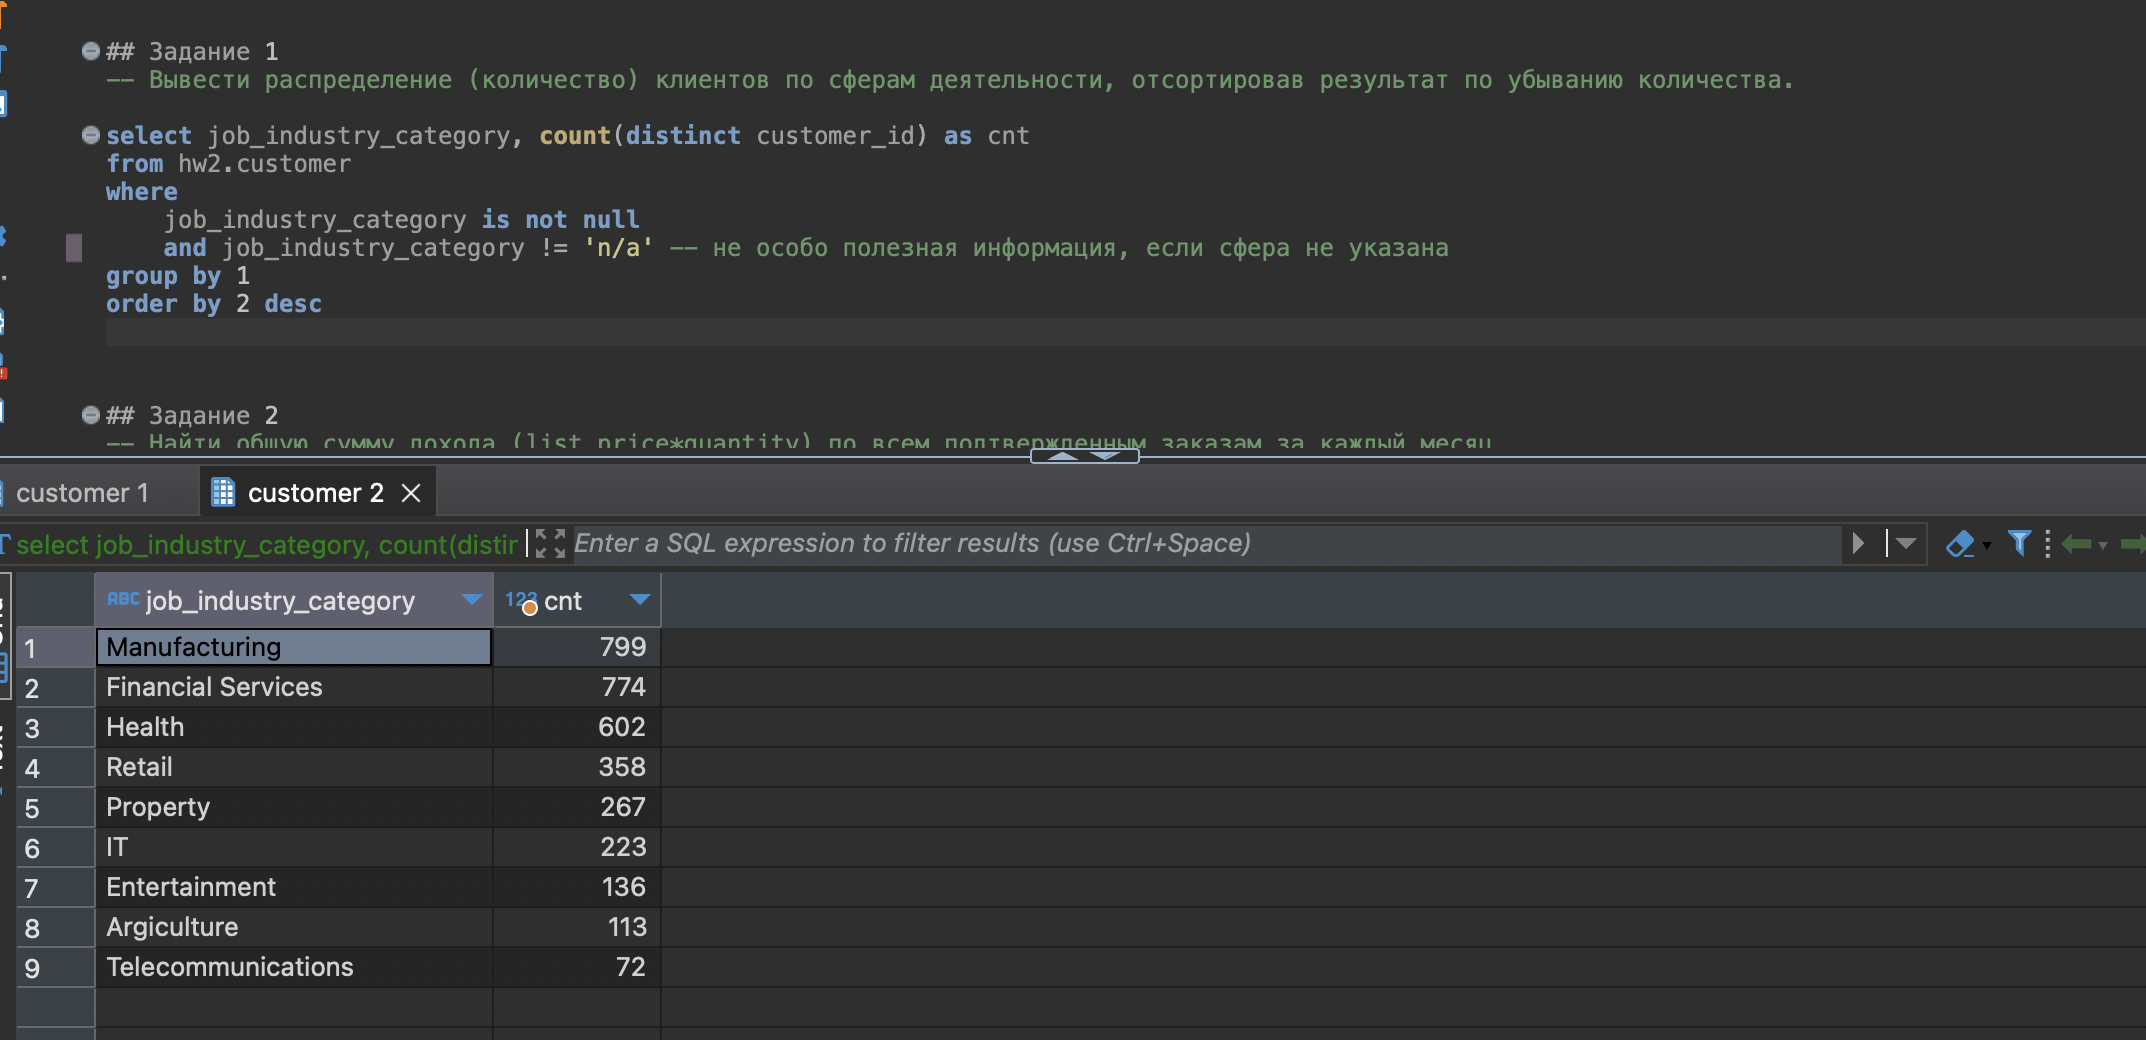

## Задание 2
-- Найти общую сумму дохода (list_price*quantity) по всем подтвержденным заказам за каждый месяц
-- по сферам деятельности клиентов. Отсортировать результат по году, месяцу и сфере деятельности.
```
select 
	extract (year from orders.order_date) as order_year
	,extract (month from orders.order_date) as order_month
	,customer.job_industry_category
	,sum(order_items.item_list_price_at_sale * order_items.quantity) as total_income
from hw2.order_items 
	left join hw2.orders on order_items.order_id = orders.order_id
	left join hw2.customer on orders.customer_id = customer.customer_id
where orders.order_status = 'Approved'
group by 1,2,3
order by 1,2,3
```

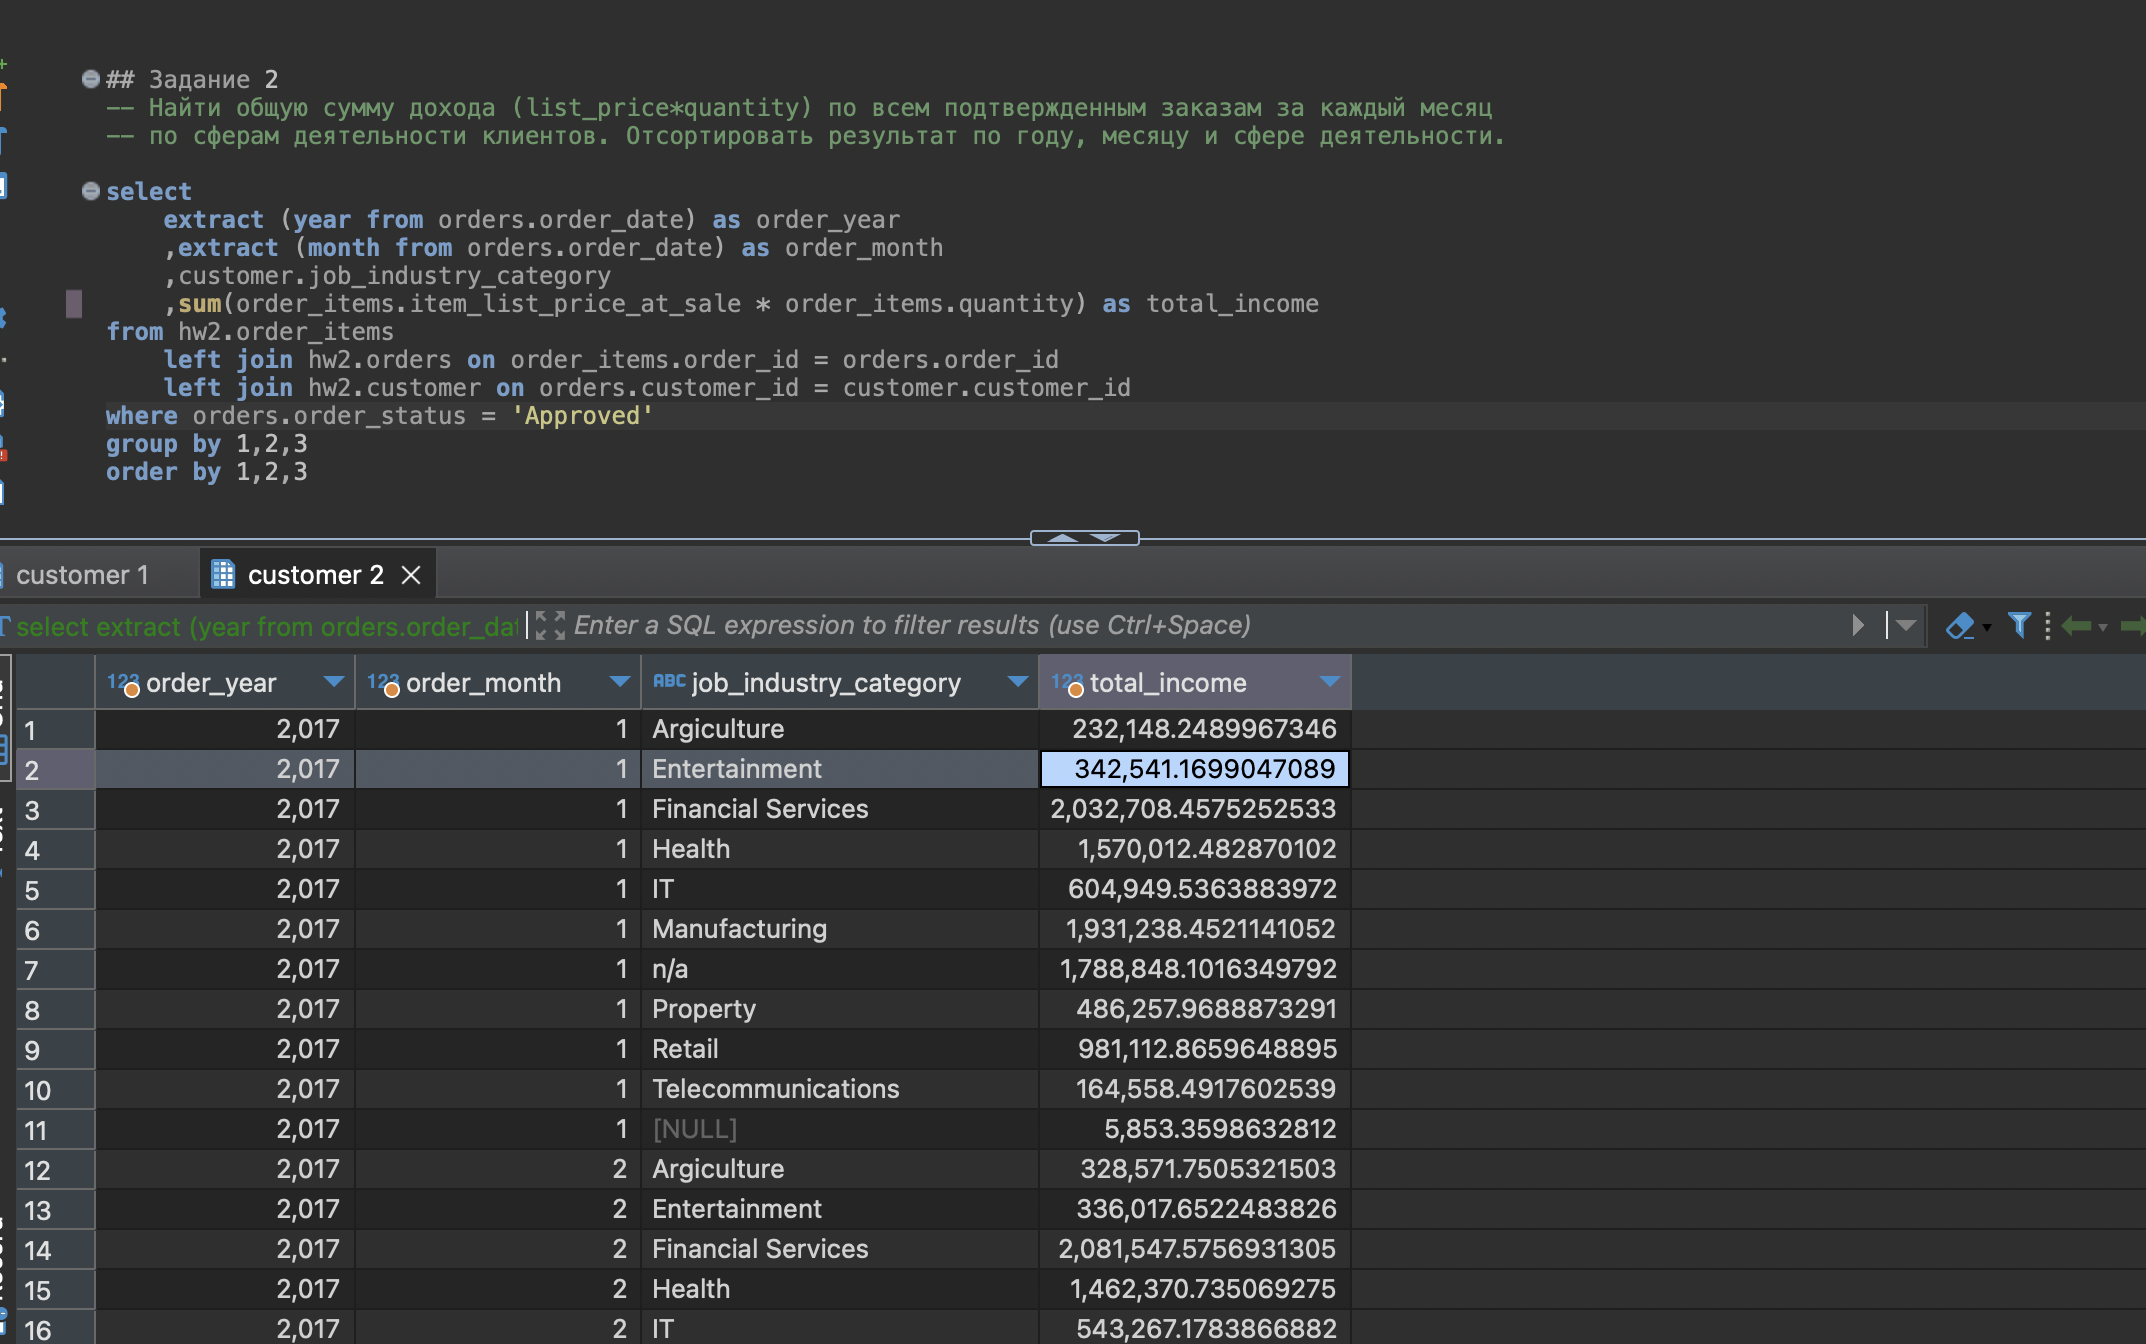

## Задание 3
```
-- Вывести количество уникальных онлайн-заказов для всех брендов в рамках подтвержденных заказов
-- клиентов из сферы IT. Включить бренды, у которых нет онлайн-заказов от IT-клиентов,
-- — для них должно быть указано количество 0.

-- брендов с нулевым количеством не нашлось в данных, но запрос такой
with all_brands as ( 
	-- достаем полный список брендов
	select distinct brand from hw2.product_cor 
),
brand_orders as (
	-- достаем количество заказов по брендам
	select 
		product_cor.brand,
		coalesce(count(orders.order_id),0) as cnt
	from hw2.orders
		left join hw2.order_items on order_items.order_id = orders.order_id
		left join hw2.customer on orders.customer_id = customer.customer_id
		left join hw2.product_cor on order_items.product_id = product_cor.product_id
	where 
		orders.order_status = 'Approved'
		and orders.online_order
		and customer.job_industry_category = 'IT'
	group by 1
)
-- наджойниваем таблицу с количеством заказов на полный список брендов
-- если для бренда нет количества, указываем 0
select 
	all_brands.brand,
	coalesce(brand_orders.cnt,0) as cnt
from all_brands
left join brand_orders using (brand)
```

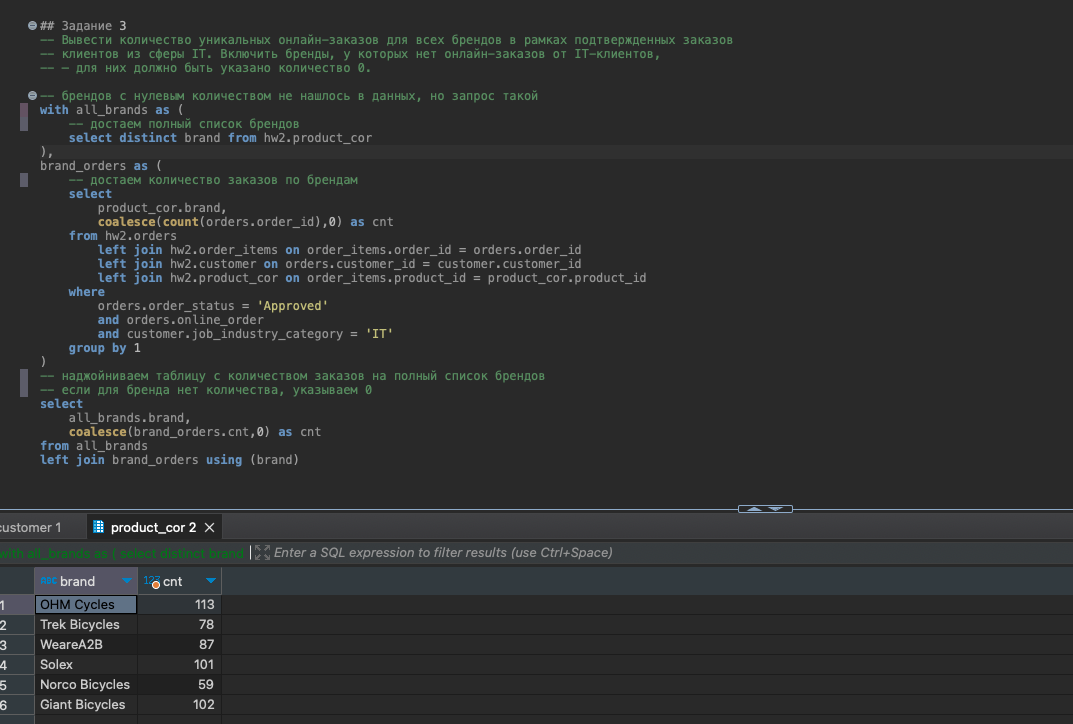

## Задание 4.1
```
-- Найти по всем клиентам: сумму всех заказов (общего дохода), максимум, минимум и
-- количество заказов, а также среднюю сумму заказа по каждому к![plan_4_1.png](attachment:plan_4_1.png)лиенту. Отсортировать
-- результат по убыванию суммы всех заказов и количества заказов. 
-- Выполнить двумя способами: используя только GROUP BY и используя только оконные функции. Сравнить результат.

select 
	orders.customer_id
	,sum(order_items.item_list_price_at_sale * order_items.quantity) as total_income
	,max(order_items.quantity) as max_quantity
	,min(order_items.quantity) as min_quantity
	,sum(order_items.quantity) as total_quantity
	,avg(order_items.item_list_price_at_sale * order_items.quantity) as avg_income
from hw2.order_items 
	left join hw2.orders on order_items.order_id = orders.order_id
	left join hw2.customer on orders.customer_id = customer.customer_id
group by 1
order by 2 desc, 5 desc
```

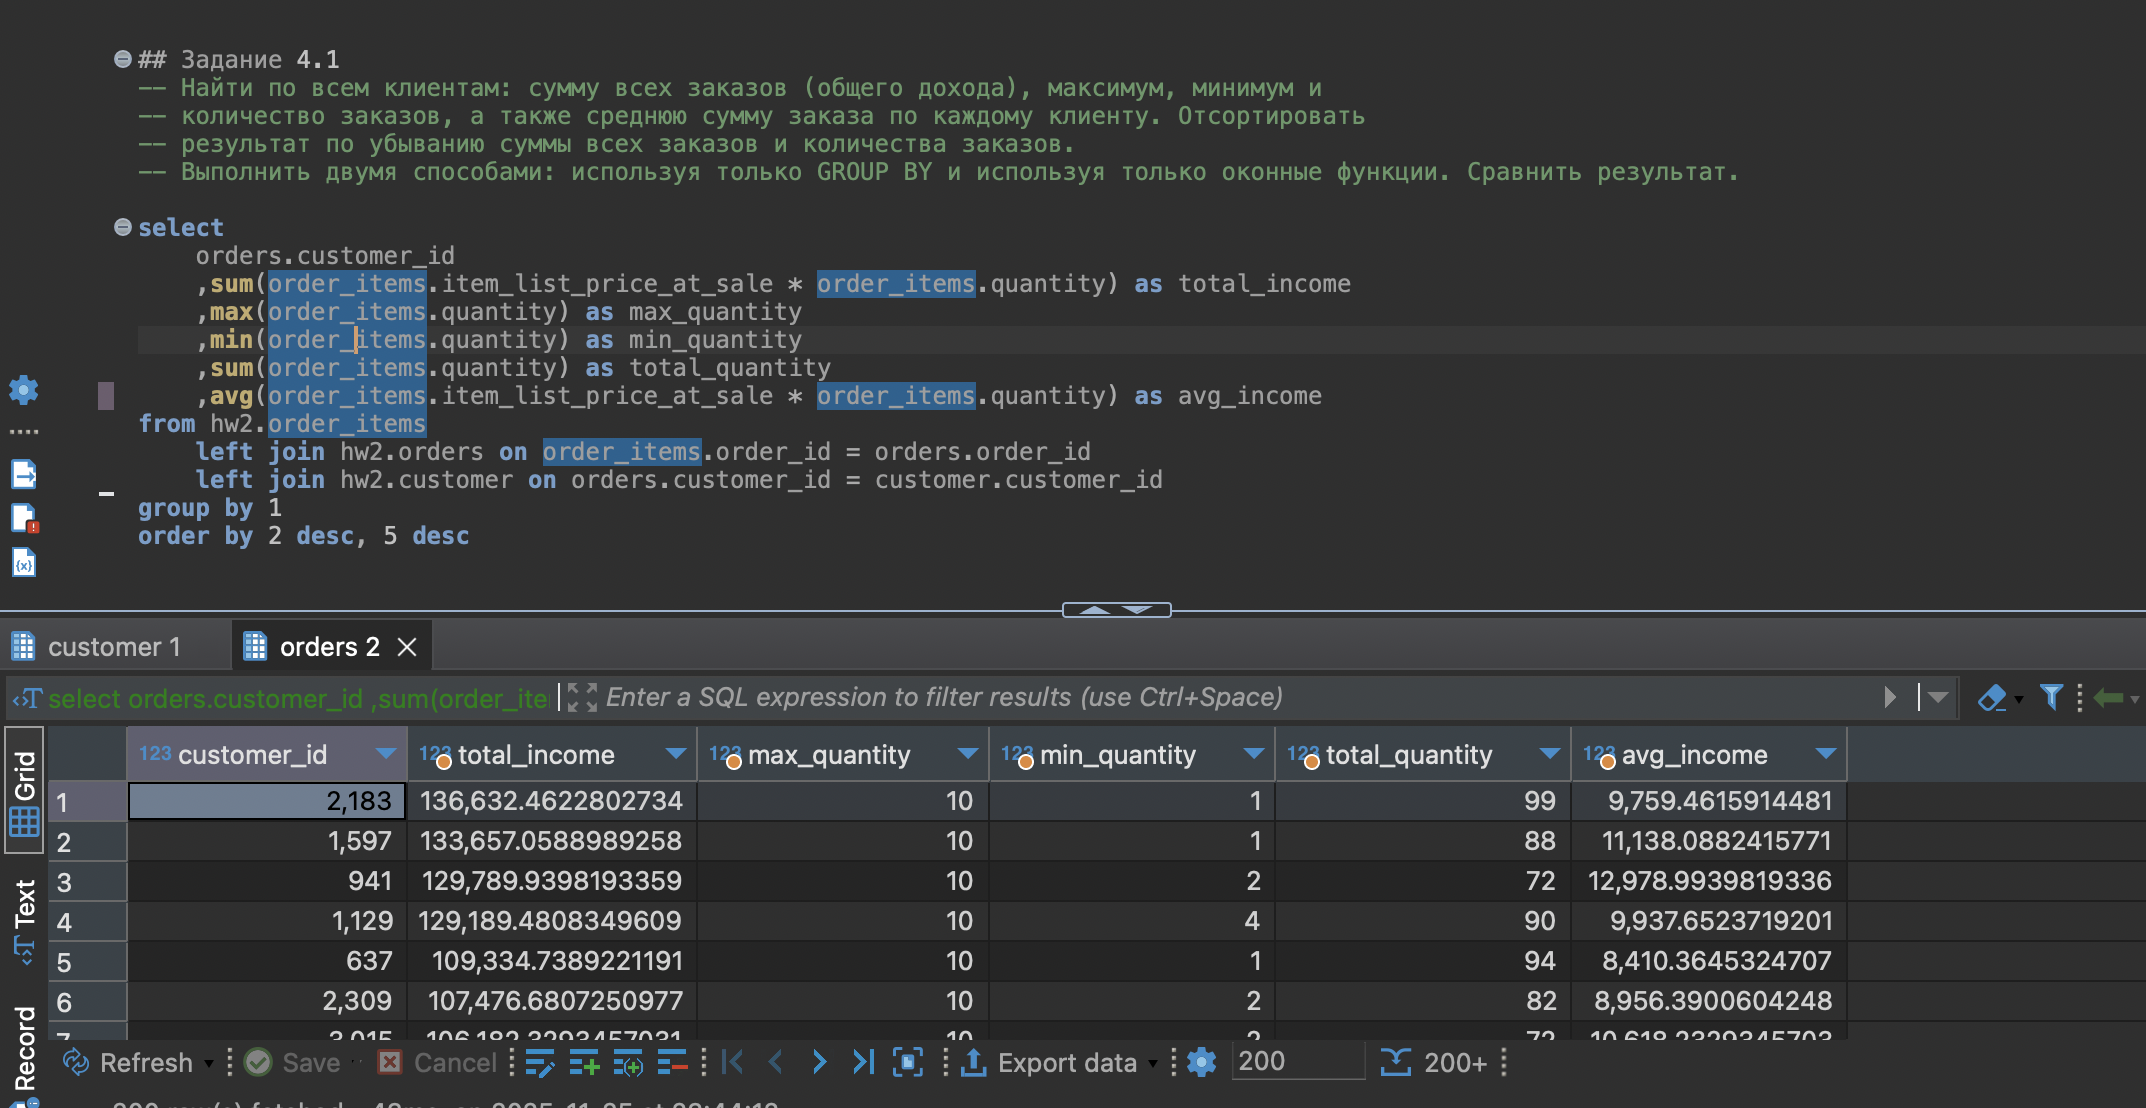

## Задание 4.2

```
select 
	distinct orders.customer_id
	,sum(order_items.item_list_price_at_sale * order_items.quantity) over (partition by orders.customer_id) as total_income
	,max(order_items.quantity) over (partition by orders.customer_id) as max_quantity
	,min(order_items.quantity) over (partition by orders.customer_id) as min_quantity
	,sum(order_items.quantity) over (partition by orders.customer_id) as total_quantity
	,avg(order_items.item_list_price_at_sale * order_items.quantity) over (partition by orders.customer_id) as avg_income
from hw2.order_items 
	left join hw2.orders on order_items.order_id = orders.order_id
	left join hw2.customer on orders.customer_id = customer.customer_id
order by 2 desc, 5 desc
```

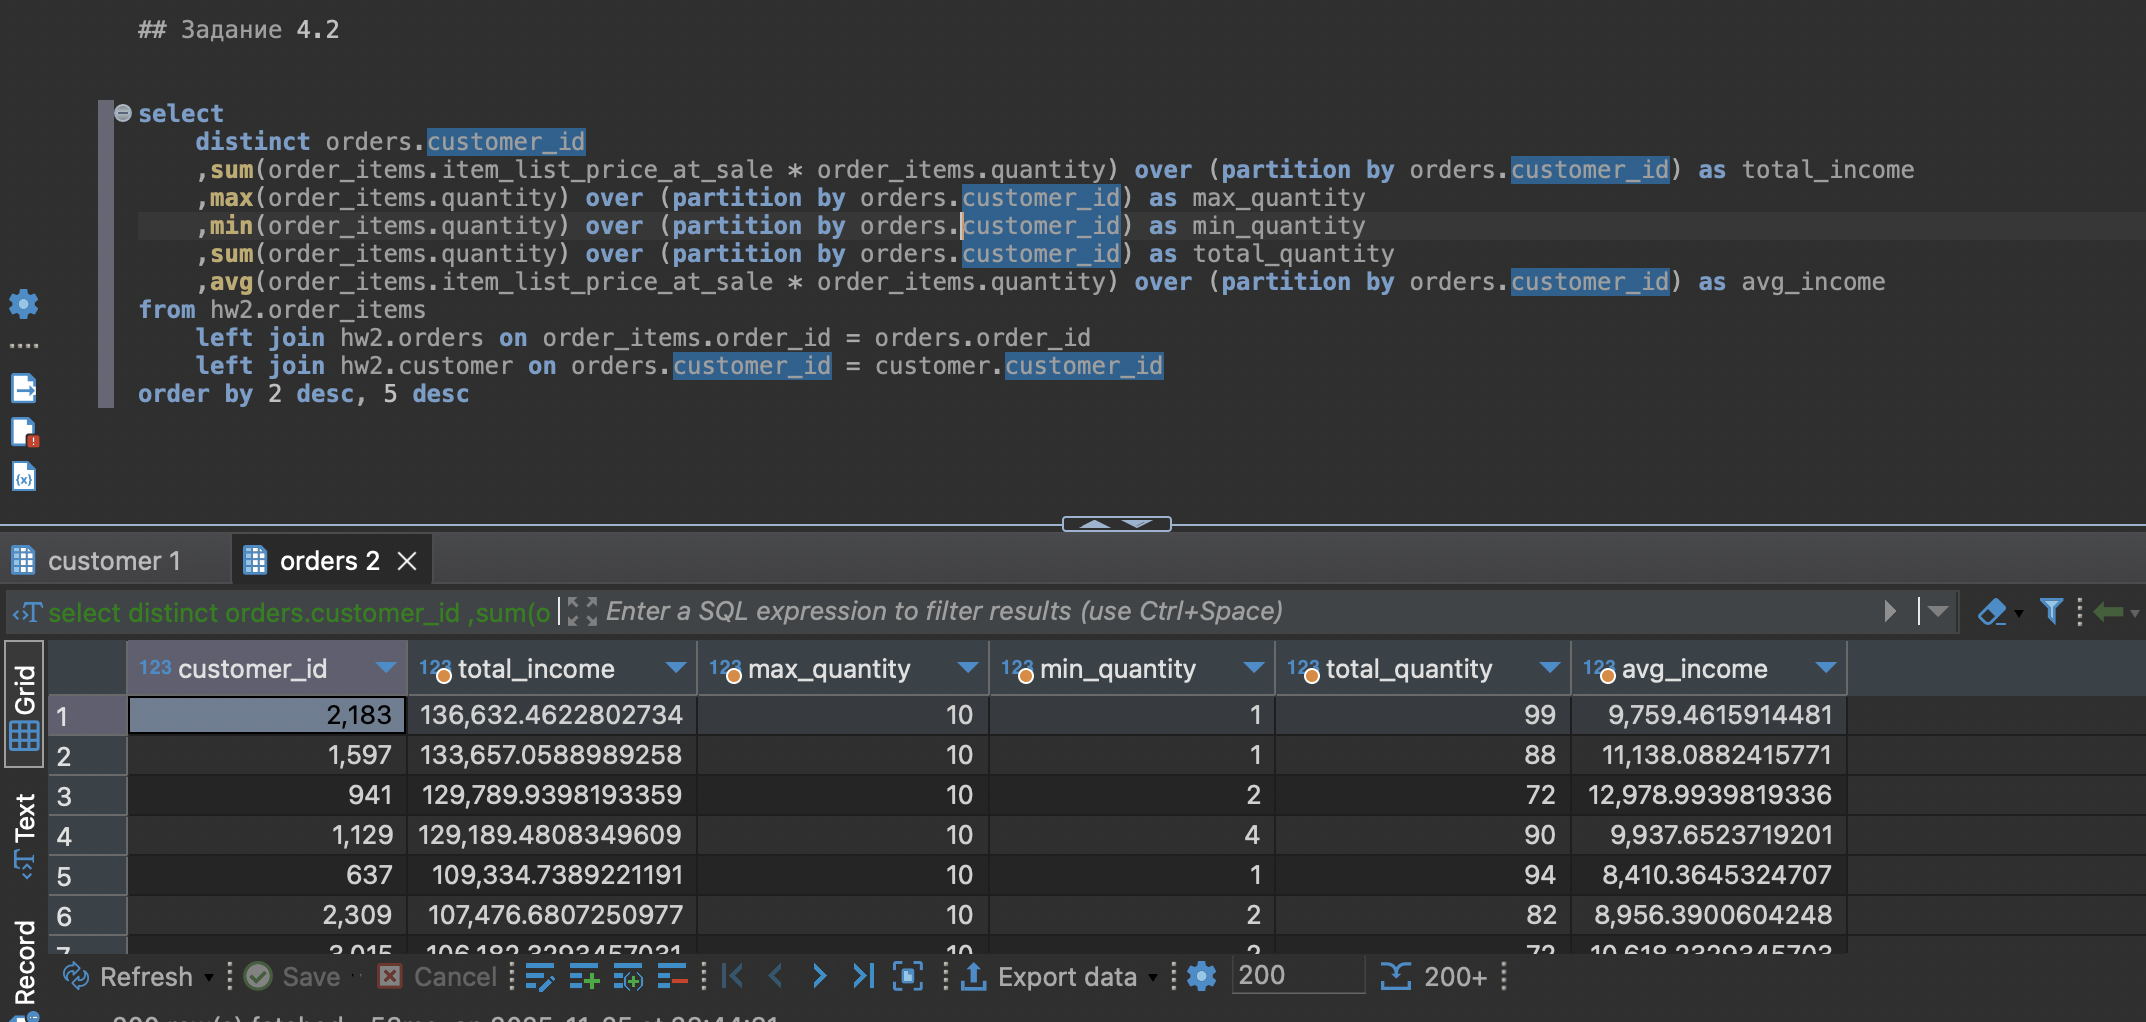

## Задание 4 - вывод 1
```
-- Найдем разницу в результатах 1 и 2 варанта. Спойлер - разницы нет

with variant_1 as (
	select 
		orders.customer_id
		,sum(order_items.item_list_price_at_sale * order_items.quantity) as total_income
		,max(order_items.quantity) as max_quantity
		,min(order_items.quantity) as min_quantity
		,sum(order_items.quantity) as total_quantity
		,avg(order_items.item_list_price_at_sale * order_items.quantity) as avg_income
	from hw2.order_items 
		left join hw2.orders on order_items.order_id = orders.order_id
		left join hw2.customer on orders.customer_id = customer.customer_id
	group by 1
	order by 2 desc, 5 desc
),
variant_2 as (
	select 
		distinct orders.customer_id
		,sum(order_items.item_list_price_at_sale * order_items.quantity) over (partition by orders.customer_id) as total_income
		,max(order_items.quantity) over (partition by orders.customer_id) as max_quantity
		,min(order_items.quantity) over (partition by orders.customer_id) as min_quantity
		,sum(order_items.quantity) over (partition by orders.customer_id) as total_quantity
		,avg(order_items.item_list_price_at_sale * order_items.quantity) over (partition by orders.customer_id) as avg_income
	from hw2.order_items 
		left join hw2.orders on order_items.order_id = orders.order_id
		left join hw2.customer on orders.customer_id = customer.customer_id
	order by 2 desc, 5 desc
)
	select *
	from variant_1
except
	select *
	from variant_2
```

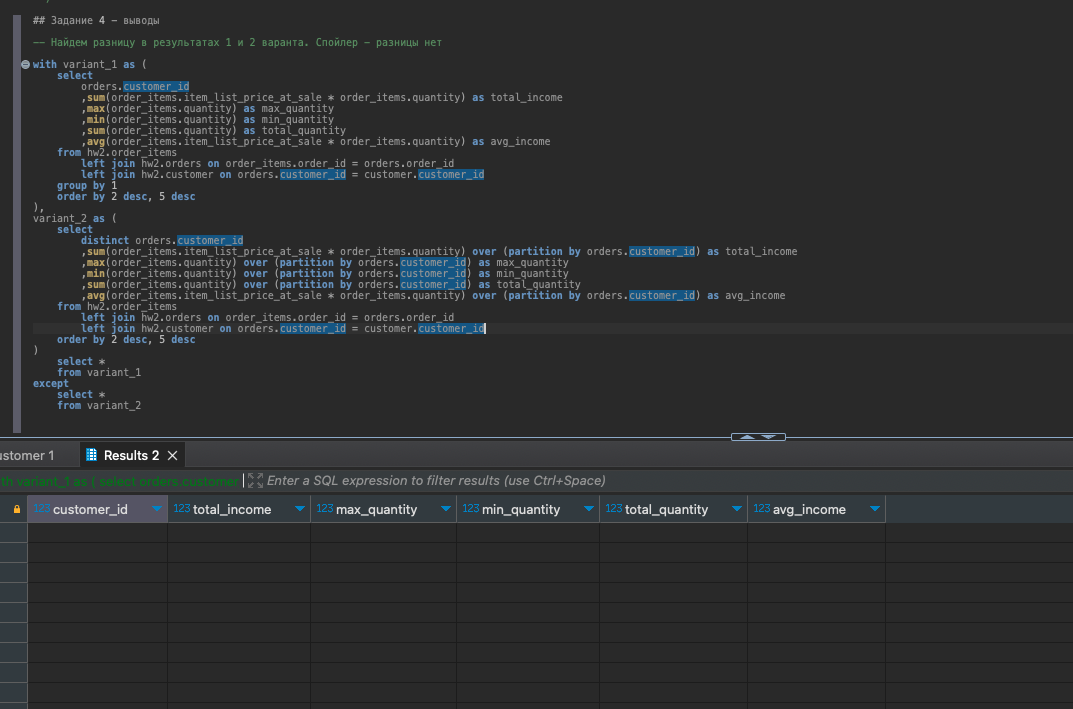

## Задание 4 - вывод 2

Но есть нюанс в виде плана запроса.

### Выводы по планам:
group by запрос выполняется значительно быстрее - 31.765 ms против 50.627 ms. Суммарное количество памяти для group by запроса также будет значительно меньше.

Для запроса с оконными функциями в плане запроса можно увидеть две сортировки (одна для окна, другая для результата запроса), отдельно дедупликация по distinct, одна оконная агрегация (одна на все 5 оконок, потому что окно одинаковое - планировщик молодец!). Вся та же логика в первом запросе реализуется с помощью только группировки и одной сортировки, что в результате гораздо проще и быстрее.

### Запрос 1 - group by

|QUERY PLAN|
|----------|
|Sort  (cost=2371.31..2380.04 rows=3494 width=36) (actual time=31.196..31.415 rows=3494.00 loops=1)|
|  Sort Key: (sum((order_items.item_list_price_at_sale * (order_items.quantity)::double precision))) DESC, (sum(order_items.quantity)) DESC|
|  Sort Method: quicksort  Memory: 288kB|
|  Buffers: shared hit=332|
|  ->  HashAggregate  (cost=2122.00..2165.68 rows=3494 width=36) (actual time=29.457..30.149 rows=3494.00 loops=1)|
|        Group Key: orders.customer_id|
|        Batches: 1  Memory Usage: 913kB|
|        Buffers: shared hit=332|
|        ->  Hash Left Join  (cost=744.00..1622.00 rows=20000 width=12) (actual time=11.234..22.996 rows=20000.00 loops=1)|
|              Hash Cond: (orders.customer_id = customer.customer_id)|
|              Buffers: shared hit=332|
|              ->  Hash Left Join  (cost=578.00..1181.00 rows=20000 width=12) (actual time=9.798..17.238 rows=20000.00 loops=1)|
|                    Hash Cond: (order_items.order_id = orders.order_id)|
|                    Buffers: shared hit=256|
|                    ->  Seq Scan on order_items  (cost=0.00..328.00 rows=20000 width=12) (actual time=0.073..1.766 rows=20000.00 loops=1)|
|                          Buffers: shared hit=128|
|                    ->  Hash  (cost=328.00..328.00 rows=20000 width=8) (actual time=9.668..9.669 rows=20000.00 loops=1)|
|                          Buckets: 32768  Batches: 1  Memory Usage: 1038kB|
|                          Buffers: shared hit=128|
|                          ->  Seq Scan on orders  (cost=0.00..328.00 rows=20000 width=8) (actual time=0.055..3.970 rows=20000.00 loops=1)|
|                                Buffers: shared hit=128|
|              ->  Hash  (cost=116.00..116.00 rows=4000 width=4) (actual time=1.422..1.423 rows=4000.00 loops=1)|
|                    Buckets: 4096  Batches: 1  Memory Usage: 173kB|
|                    Buffers: shared hit=76|
|                    ->  Seq Scan on customer  (cost=0.00..116.00 rows=4000 width=4) (actual time=0.026..0.810 rows=4000.00 loops=1)|
|                          Buffers: shared hit=76|
|Planning Time: 0.566 ms|
|Execution Time: 31.765 ms|


### Запрос 2 - window functions

|QUERY PLAN|
|----------|
|Unique  (cost=5229.54..5579.54 rows=20000 width=36) (actual time=46.947..49.862 rows=3494.00 loops=1)|
|  Buffers: shared hit=332|
|  ->  Sort  (cost=5229.54..5279.54 rows=20000 width=36) (actual time=46.946..47.952 rows=20000.00 loops=1)|
|        Sort Key: (sum((order_items.item_list_price_at_sale * (order_items.quantity)::double precision)) OVER w1) DESC, (sum(order_items.quantity) OVER w1) DESC, orders.customer_id, (max(order_items.quantity) OVER w1), (min(order_items.quantity) OVER w1), (avg((order_items.item_list_price_at_sale * (order_items.quantity)::double precision)) OVER w1)|
|        Sort Method: quicksort  Memory: 1862kB|
|        Buffers: shared hit=332|
|        ->  WindowAgg  (cost=3050.96..3800.77 rows=20000 width=36) (actual time=28.925..38.823 rows=20000.00 loops=1)|
|              Window: w1 AS (PARTITION BY orders.customer_id)|
|              Storage: Memory  Maximum Storage: 17kB|
|              Buffers: shared hit=332|
|              ->  Sort  (cost=3050.77..3100.77 rows=20000 width=12) (actual time=28.881..30.359 rows=20000.00 loops=1)|
|                    Sort Key: orders.customer_id|
|                    Sort Method: quicksort  Memory: 1394kB|
|                    Buffers: shared hit=332|
|                    ->  Hash Left Join  (cost=744.00..1622.00 rows=20000 width=12) (actual time=11.398..21.893 rows=20000.00 loops=1)|
|                          Hash Cond: (orders.customer_id = customer.customer_id)|
|                          Buffers: shared hit=332|
|                          ->  Hash Left Join  (cost=578.00..1181.00 rows=20000 width=12) (actual time=8.542..15.451 rows=20000.00 loops=1)|
|                                Hash Cond: (order_items.order_id = orders.order_id)|
|                                Buffers: shared hit=256|
|                                ->  Seq Scan on order_items  (cost=0.00..328.00 rows=20000 width=12) (actual time=0.181..2.300 rows=20000.00 loops=1)|
|                                      Buffers: shared hit=128|
|                                ->  Hash  (cost=328.00..328.00 rows=20000 width=8) (actual time=8.166..8.167 rows=20000.00 loops=1)|
|                                      Buckets: 32768  Batches: 1  Memory Usage: 1038kB|
|                                      Buffers: shared hit=128|
|                                      ->  Seq Scan on orders  (cost=0.00..328.00 rows=20000 width=8) (actual time=0.076..4.879 rows=20000.00 loops=1)|
|                                            Buffers: shared hit=128|
|                          ->  Hash  (cost=116.00..116.00 rows=4000 width=4) (actual time=2.835..2.835 rows=4000.00 loops=1)|
|                                Buckets: 4096  Batches: 1  Memory Usage: 173kB|
|                                Buffers: shared hit=76|
|                                ->  Seq Scan on customer  (cost=0.00..116.00 rows=4000 width=4) (actual time=0.040..2.299 rows=4000.00 loops=1)|
|                                      Buffers: shared hit=76|
|Planning Time: 1.000 ms|
|Execution Time: 50.627 ms|


## Задание 5
```
-- Найти имена и фамилии клиентов с топ-3 минимальной и топ-3 максимальной суммой транзакций
-- за весь период (учесть клиентов, у которых нет заказов, приняв их сумму транзакций за 0).

with raw_rating as(
		(select 
			customer.first_name
			,customer.last_name
			 -- вдруг список кастомеров в разных таблицах разный:
			,coalesce(customer.customer_id, orders.customer_id) as customer_id
			,coalesce(sum(order_items.item_list_price_at_sale * order_items.quantity),0) as total_income
		from hw2.order_items 
			left join hw2.orders on order_items.order_id = orders.order_id
			left join hw2.customer on orders.customer_id = customer.customer_id
		where coalesce(customer.customer_id, orders.customer_id)  is not null
		group by 1,2,3
		order by 4
		limit 3)
	union all
		(select 
		customer.first_name
		,customer.last_name
		 -- вдруг список кастомеров в разных таблицах разный:
		,coalesce(customer.customer_id, orders.customer_id) as customer_id
		,coalesce(sum(order_items.item_list_price_at_sale * order_items.quantity),0) as total_income
		from hw2.order_items 
			left join hw2.orders on order_items.order_id = orders.order_id
			left join hw2.customer on orders.customer_id = customer.customer_id
		where coalesce(customer.customer_id, orders.customer_id)  is not null
		group by 1,2,3
		order by 4 desc
		limit 3)
)
select 
	first_name,
	last_name,
	customer_id
from raw_rating
```

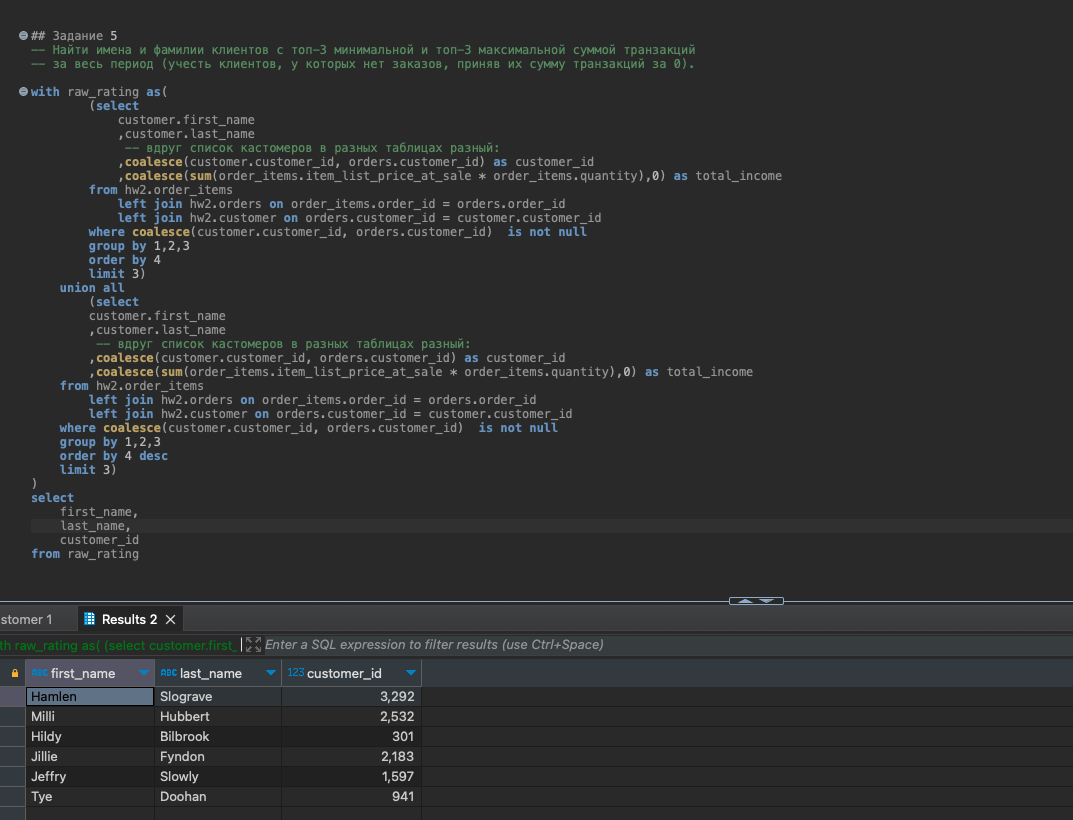

## Задание 6
```
-- Вывести только вторые транзакции клиентов (если они есть) с помощью оконных функций.
-- Если у клиента меньше двух транзакций, он не должен попасть в результат.

select 
	customer_id
	,order_id
from (
	select 
		orders.customer_id
		,orders.order_id
		,row_number() over (partition by orders.customer_id order by order_date) as ordinal_order_number
	from hw2.orders ) t
where ordinal_order_number = 2
```

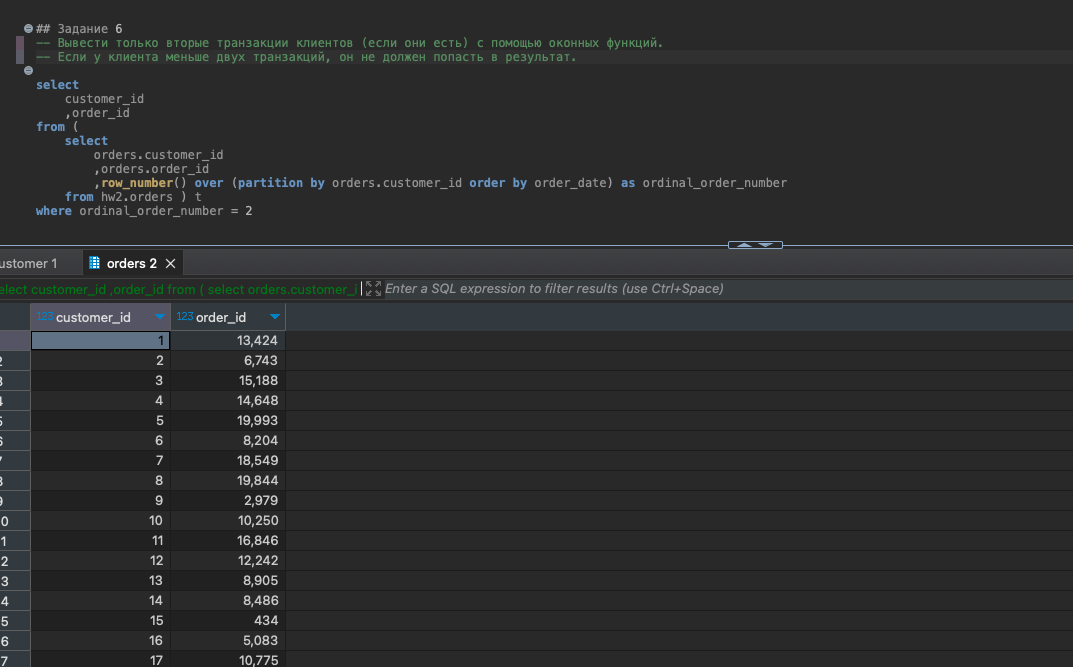

## Задание 7
```
-- Вывести имена, фамилии и профессии клиентов, а также длительность максимального интервала (в днях) между двумя
-- последовательными заказами. Исключить клиентов, у которых только один или меньше заказов.

with raw as (
	select 
		customer.first_name
		,customer.last_name
		 -- вдруг список кастомеров в разных таблицах разный:
		,coalesce(customer.customer_id, orders.customer_id) as customer_id
		,orders.order_date
		,lag(order_date) over (partition by coalesce(customer.customer_id, orders.customer_id) order by order_date) as previous_order_date
	from hw2.order_items 
		left join hw2.orders on order_items.order_id = orders.order_id
		left join hw2.customer on orders.customer_id = customer.customer_id
	where coalesce(customer.customer_id, orders.customer_id)  is not null
)
select 
	first_name
	,last_name
	,customer_id 
	,max(order_date - previous_order_date) as max_date_diff
from raw
where previous_order_date is not null -- это сразу отрежет людей, у которых одна транзакция или меньше
group by 1,2,3
```

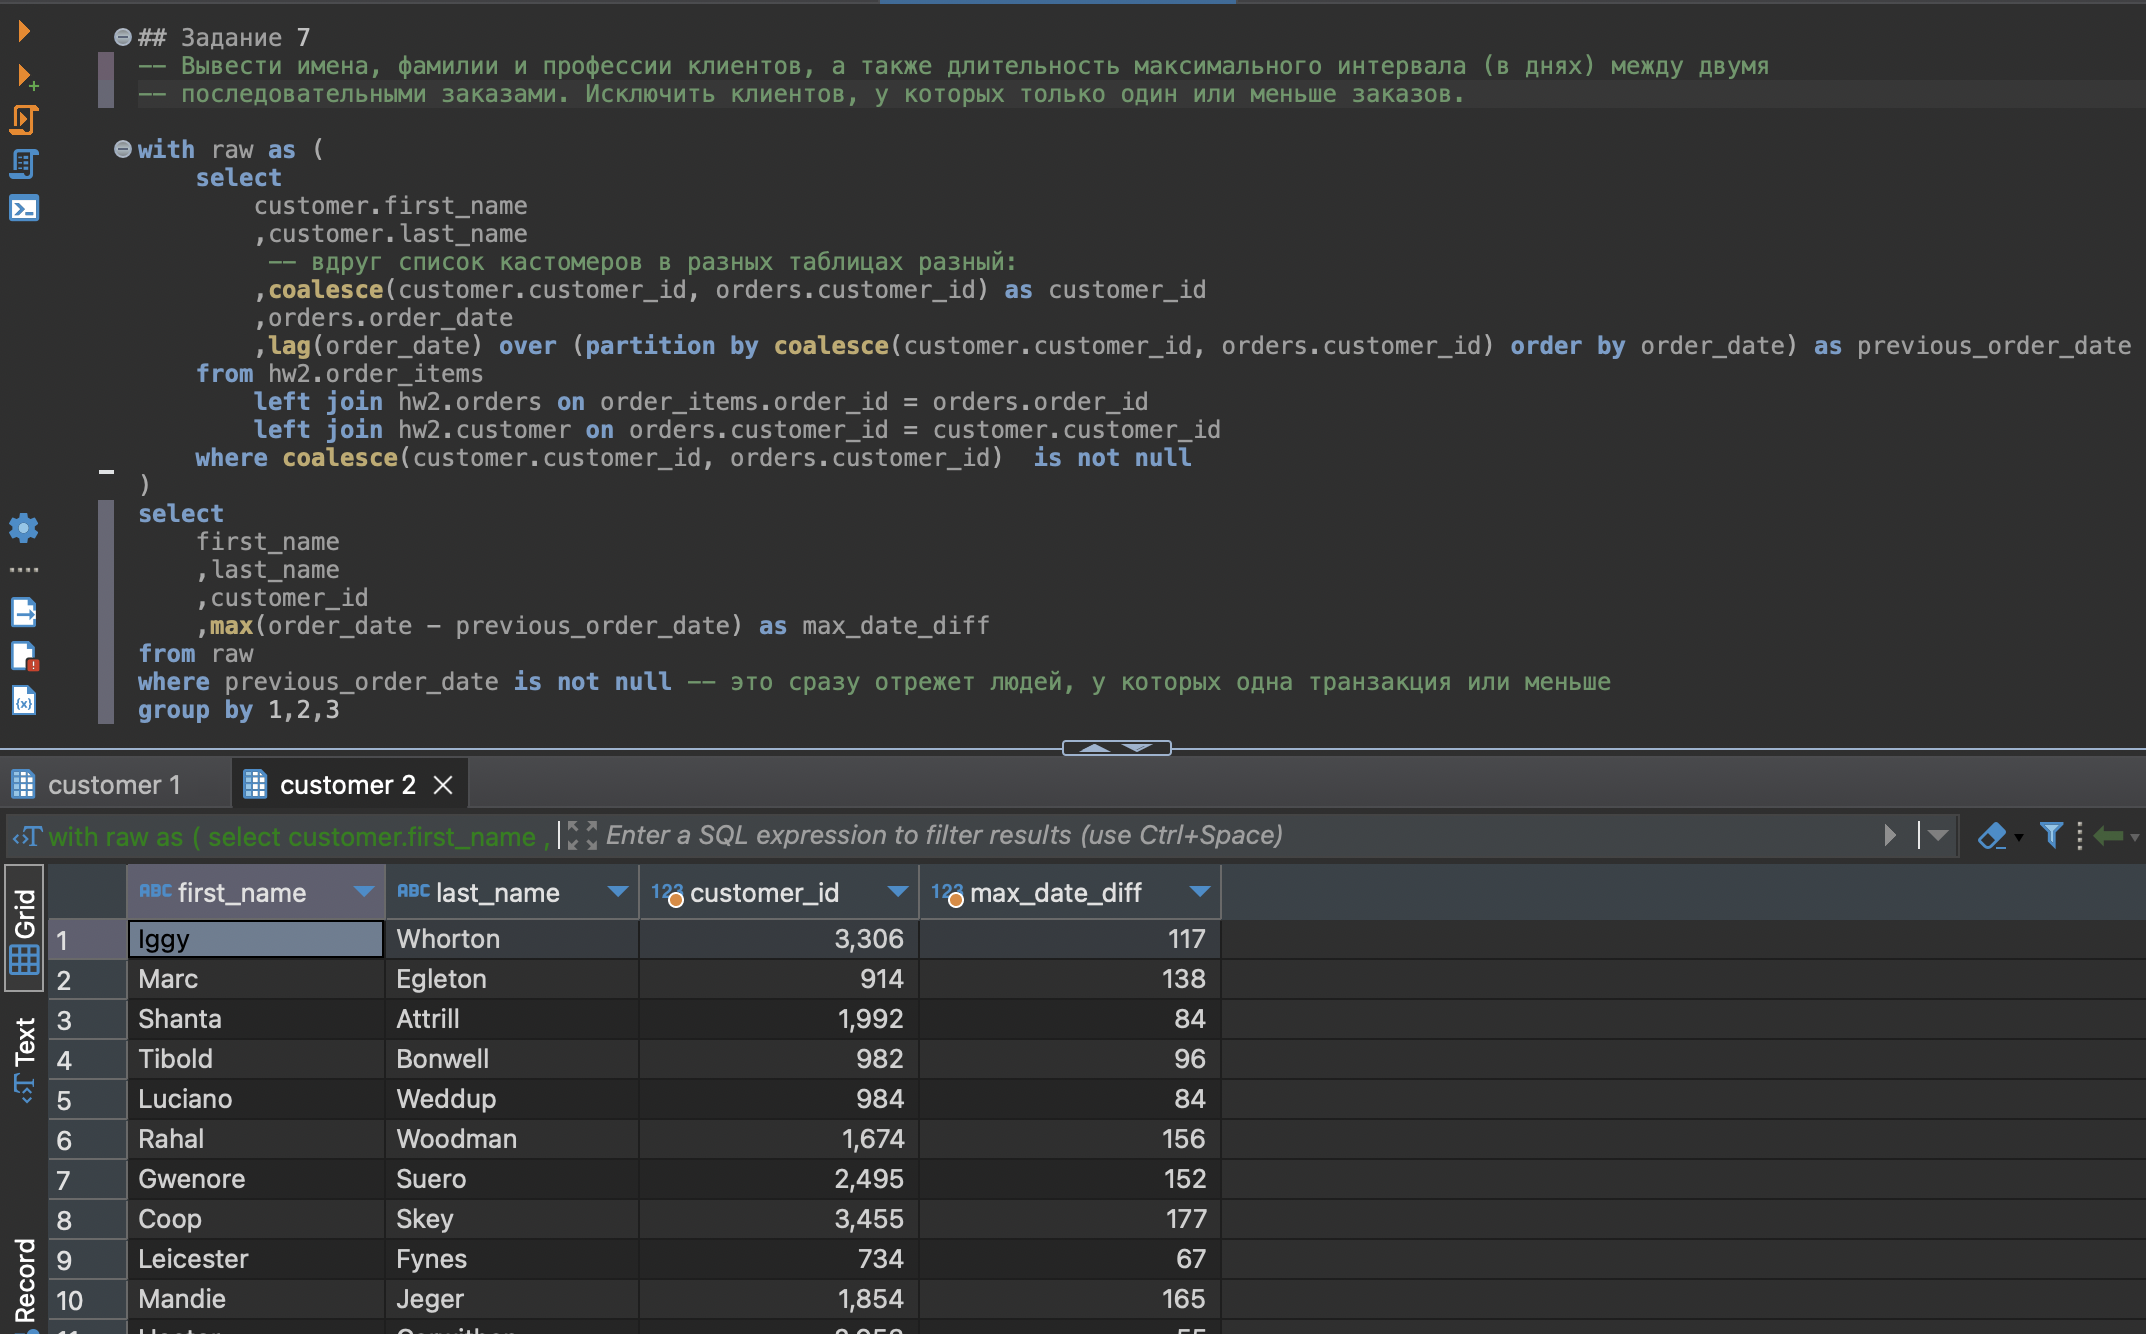

## Задание 8
```
-- Найти топ-5 клиентов (по общему доходу) в каждом сегменте благосостояния (wealth_segment).
-- Вывести имя, фамилию, сегмент и общий доход. Если в сегменте менее 5 клиентов, вывести всех.

-- тут большой вопрос с тем, по какой логике обрабатывать клиентов с равным уровнем трат в одном сегменте,
-- от этого будет зависеть выбор между rown_number, rank и dense_rank. 
-- однако rank и dense_rank в теории могли бы вернуть больше 5 клиентов, поэтому выбираю rown_number

with income as (
	select 
		customer.first_name
		,customer.last_name
		 -- вдруг список кастомеров в разных таблицах разный:
		,coalesce(customer.customer_id, orders.customer_id) as customer_id
		,wealth_segment
		,coalesce(sum(order_items.item_list_price_at_sale * order_items.quantity),0) as total_income
	from hw2.order_items 
		left join hw2.orders on order_items.order_id = orders.order_id
		left join hw2.customer on orders.customer_id = customer.customer_id
	where coalesce(customer.customer_id, orders.customer_id)  is not null
		and wealth_segment  is not null
	group by 1,2,3,4
)
select *
from (
	select 
		*
		,row_number() over (partition by wealth_segment order by total_income desc) as place_within_segment
	from income ) t
where place_within_segment <=5
```

![result_8.png](attachment:result_8.png)